# EarthCube Graph Analytics Exploration

## About

This is the start of learning a bit about leveraging graph analytics to assess the 
EarthCube graph and explore both the relationships but also look for methods to 
better search the graph for relevant connections.

## Thoughts
It seems we don't care about the triples with literal objects.  Only the triples 
that represent connections between types.   Could we use a CONSTRUCT call to 
remove the unwanted triples?  Filter on only IRI to IRI.    

## References

* [RDFLib](https://github.com/RDFLib/rdflib)
* [NetworkX](https://networkx.org/)
* [iGraph](https://igraph.org/)
* [NetworkX link analysis](https://networkx.org/documentation/latest/reference/algorithms/link_analysis.html?highlight=page%20rank#)
* https://faculty.math.illinois.edu/~riveraq2/teaching/simcamp16/PageRankwithPython.html
* https://docs.dask.org/en/latest/
* https://examples.dask.org/bag.html
* https://s3fs.readthedocs.io/en/latest/
* https://docs.dask.org/en/latest/remote-data-services.html

## Installs

In [1]:
!pip -q install mimesis
!pip -q install minio 
!pip -q install s3fs
!pip -q install SPARQLWrapper
!pip -q install boto3
!pip -q install 'fsspec>=0.3.3'
!pip -q install rdflib
!pip -q install rdflib-jsonld
!pip -q install PyLD==2.0.2
!pip -q install networkx

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

boto3 1.17.46 requires botocore<1.21.0,>=1.20.46, but you'll have botocore 1.19.52 which is incompatible.


ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

aiobotocore 1.2.2 requires botocore<1.19.53,>=1.19.52, but you'll have botocore 1.20.71 which is incompatible.


In [2]:
import sys
sys.path.append("../lib/")  # path contains python_file.py

import sparqlPandas

## Imports


In [3]:
import dask, boto3
import dask.dataframe as dd
import pandas as pd
import json

from SPARQLWrapper import SPARQLWrapper, JSON

sweet = "http://cor.esipfed.org/sparql"
dbsparql = "http://dbpedia.org/sparql"
ufokn = "http://graph.ufokn.org/blazegraph/namespace/ufokn-dev/sparql"

## Code inits

### Helper function(s)
The following block is a SPARQL to Pandas feature.  You may need to run it to load the function per standard notebook actions.

In [4]:
#@title
def get_sparql_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

### Set up some Pandas Dataframe options

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Set up the connection to the object store to access the graph objects from

In [6]:
import s3fs 

oss = s3fs.S3FileSystem(
      anon=True,
      key="",
      secret="",
      client_kwargs = {"endpoint_url":"https://oss.geodex.org"}
   )

In [7]:
# Simple command to list objects in the current results bucket prefix
oss.ls('gleaner/results/cdfv3')

['gleaner/results/cdfv3/bcodmo_graph.nq',
 'gleaner/results/cdfv3/cchdo_graph.nq',
 'gleaner/results/cdfv3/earthchem_graph.nq',
 'gleaner/results/cdfv3/hydroshare_graph.nq',
 'gleaner/results/cdfv3/ieda_graph.nq',
 'gleaner/results/cdfv3/iris_graph.nq',
 'gleaner/results/cdfv3/lipdverse_graph.nq',
 'gleaner/results/cdfv3/ocd_graph.nq',
 'gleaner/results/cdfv3/opentopo_graph.nq',
 'gleaner/results/cdfv3/ssdb_graph.nq',
 'gleaner/results/cdfv3/unavco_graph.nq']

## Pull a graph and load

Let's pull back an example graph and load it up into an RDFLib graph so we can test out a SPARQL call on it.

In [8]:
import rdflib
import gzip

with oss.open('gleaner/results/cdfv3/opentopo_graph.nq', 'rb') as f:
  #print(f.read())
  file_content = f.read()  #.decode("utf-8", "ignore").replace('\n',' ')

# print(file_content)    
# with gzip.open('./oceanexperts_graph.nq.gz', 'rb') as f:
#     file_content = f.read()


In [9]:
g = rdflib.Graph()
parsed = g.parse(data = file_content, format="nquads")


## Note

When we start to do the network analysis we don't really care about the links to literal strings.
Rather, we want to see connections between various types.  More specidically, types connecting to types.

Note, the isIRI filter removes the blank nodes since the rdf:type can point to both IRI and blank nodes.

           BIND("Nca34627a4b6d4272be7e2d22bab3becd" as ?s)


```SPARQL
    prefix schema: <http://schema.org/>
    SELECT DISTINCT ?s ?o 
       WHERE {
           ?s  a schema:Dataset. 
           ?s ?p ?o .
           ?o a ?type
           FILTER isIRI(?o)
       }
     LIMIT 1000
```

In [10]:
qres = g.query(
    """prefix schema: <https://schema.org/>
    SELECT DISTINCT ?s ?o 
       WHERE {
           ?s  a schema:Dataset. 
           ?s ?p ?o .
           ?o a ?type  
           FILTER isIRI(?o)
       }
       LIMIT 1000
       """)

qrdf = pd.DataFrame(columns=['s', 'o'])

for row in qres:
    qrdf = qrdf.append({'s': row[0], 'o': row[1]}, ignore_index=True)
#     print("%s : %s " % row)

KeyboardInterrupt: 

In [47]:
qrdf.head()

,s,o
0,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.072018.6340.1,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.072018.6340.1
1,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.052018.2444.2,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.052018.2444.2
2,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.122016.2193.6,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.122016.2193.6
3,https://portal.opentopography.org/raster?opentopoID=OTSDEM.082019.26912.1,https://portal.opentopography.org/raster?opentopoID=OTSDEM.082019.26912.1
4,https://portal.opentopography.org/raster?opentopoID=OTSDEM.012012.26915.1,https://portal.opentopography.org/raster?opentopoID=OTSDEM.012012.26915.1


## Convert to NetworkX

Convert this to a networkx graph so we can explore some analytics calls

In [48]:
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_digraph
import networkx as nx
import matplotlib.pyplot as plt

G = rdflib_to_networkx_digraph(parsed)
G=nx.from_pandas_edgelist(qrdf, source='s', target='o')


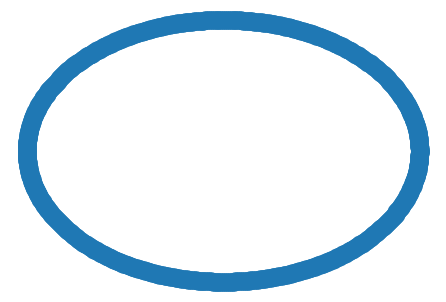

In [49]:
# Pointless to draw for a graph this big..   just a black ball
nx.draw_circular(G, with_labels = False)
plt.show() # display

(array([  0.,   0.,   0.,   0.,   0., 654.,   0.,   0.,   0.,   0.]),
 array([1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5]),
 <BarContainer object of 10 artists>)

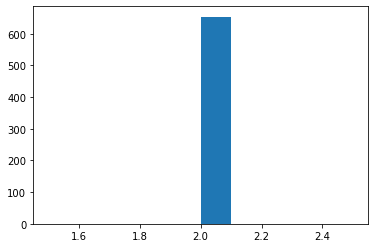

In [50]:
plt.hist([v for k,v in nx.degree(G)])

(array([  0.,   0.,   0.,   0.,   0., 654.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

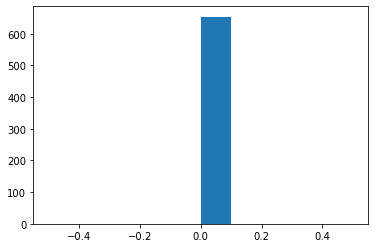

In [51]:
plt.hist(nx.centrality.betweenness_centrality(G).values())

In [52]:
#  nx.diameter(G)  # found infinite  

In [53]:
nx.cluster.average_clustering(G)

0.0

### Pagerank

Test a page rank call and see if we can load the results into Pandas and sort.

In [54]:
import pandas as pd

pr = nx.pagerank(G,alpha=0.9)

prdf = pd.DataFrame.from_dict(pr, orient='index')
prdf.sort_values(by=0,ascending=False, inplace=True,)
prdf.head(10)

,0
https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.072018.6340.1,0.001529
https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.122019.4326.5,0.001529
https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.022019.32637.5,0.001529
https://portal.opentopography.org/raster?opentopoID=OTSDEM.102012.26916.1,0.001529
https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.022012.26910.2,0.001529
https://portal.opentopography.org/raster?opentopoID=OTSDEM.072013.2965.1,0.001529
https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.112018.32635.1,0.001529
https://portal.opentopography.org/raster?opentopoID=OTSDEM.062017.26910.1,0.001529
https://portal.opentopography.org/raster?opentopoID=OTSDEM.032013.26910.2,0.001529
https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.042020.32632.1,0.001529


### NetworkX hits 


In [55]:
hits = nx.hits(G)  # can also be done with a nodelist (which is interesting.   provide with SPARQL call?)

In [56]:
hitsdf = pd.DataFrame.from_dict(hits)
hitsdf.head()

,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.072018.6340.1,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.052018.2444.2,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.122016.2193.6,https://portal.opentopography.org/raster?opentopoID=OTSDEM.082019.26912.1,https://portal.opentopography.org/raster?opentopoID=OTSDEM.012012.26915.1,https://portal.opentopography.org/raster?opentopoID=OTSDEM.032013.26918.3,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.052016.26911.1,https://portal.opentopography.org/raster?opentopoID=OTSDEM.052016.26912.3,https://portal.opentopography.org/raster?opentopoID=OTSDEM.032012.26913.1,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.122016.26910.1b,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.072017.26910.1,https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.112019.32618.1,https://portal.opentopography.org/raster?opentopoID=OTSDEM.122016.26915.1b,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.102011.26918.1,https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.062019.32633.1,https://portal.opentopography.org/raster?opentopoID=OTSDEM.032011.26910.1,https://portal.opentopography.org/raster?opentopoID=OTSDEM.062018.26911.1,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.092019.26911.1,https://portal.opentopography.org/raster?opentopoID=OTSDEM.072020.6339.2,https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.042020.32611.1,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.042012.26911.5,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.072017.26912.2,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.092016.26911.2,https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.092019.4326.1,https://portal.opentopography.org/raster?opentopoID=OTSDEM.072019.6339.2,https://portal.opentopography.org/raster?opentopoID=OTSDEM.102016.26916.1,https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.102018.32637.1,https://portal.opentopography.org/raster?opentopoID=OTSDEM.022017.26910.3,https://portal.opentopography.org/raster?opentopoID=OTSDEM.112012.26911.1,https://portal.opentopography.org/raster?opentopoID=OTSDEM.012019.26911.1,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.112015.26912.1,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.082020.2193.1,https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.092020.32715.4,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.102012.26912.4,https://portal.opentopography.org/raster?opentopoID=OTSDEM.092019.26910.1,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.042012.26911.4,https://portal.opentopography.org/raster?opentopoID=OTSDEM.082020.6343.1,https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.052019.32616.1,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.082011.26910.1,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.022014.32610.1,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.062012.26916.1,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.042017.2193.1,https://portal.opentopography.org/raster?opentopoID=OTSDEM.012013.26910.1,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.092012.26910.1,https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.022021.32719.2,https://portal.opentopography.org/raster?opentopoID=OTSDEM.052016.26912.2,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.102012.26916.1,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.042018.2193.1,https://portal.opentopography.org/raster?opentopoID=OTSDEM.092015.32611.1,https://portal.opentopography.org/raster?opentopoID=OTSDEM.062012.26913.2,https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.032012.26913.1,https://portal.opentopography.org/lidarDataset

In [57]:
bc = nx.betweenness_centrality(G)

In [58]:
bcdf = pd.DataFrame.from_dict(bc, orient='index')
bcdf.sort_values(by=0,ascending=False, inplace=True,)
bcdf.head(10)

,0
https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.072018.6340.1,0.0
https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.122019.4326.5,0.0
https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.022019.32637.5,0.0
https://portal.opentopography.org/raster?opentopoID=OTSDEM.102012.26916.1,0.0
https://portal.opentopography.org/lidarDataset?opentopoID=OTLAS.022012.26910.2,0.0
https://portal.opentopography.org/raster?opentopoID=OTSDEM.072013.2965.1,0.0
https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.112018.32635.1,0.0
https://portal.opentopography.org/raster?opentopoID=OTSDEM.062017.26910.1,0.0
https://portal.opentopography.org/raster?opentopoID=OTSDEM.032013.26910.2,0.0
https://portal.opentopography.org/dataspace/dataset?opentopoID=OTDS.042020.32632.1,0.0
